In [1]:
import pandas as pd
import numpy as np
import eia
import requests
import json
import yaml
from prophet import Prophet

# Definitions
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
pd.set_option('display.max_columns', 100)    #Display upto 100 columns 
pd.set_option('display.max_rows', 100) 
%matplotlib inline

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')   

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
# To be able to pull modules from src folder 
import os
import sys
src_dir = os.path.join(os.getcwd(), '..', 'src')
sys.path.append(src_dir)

In [3]:
from d00_utils.const import *
from d00_utils.utils import setup_env_vars, load_yml, get_filepath

setup_env_vars()
os.environ.get("EIA_ACCESS_KEY")

2022-03-03 19:26:34,649 - Finding .env file to load entries as environment variables...
2022-03-03 19:26:34,653 - Finished loading environment variables.


'xPWAeqwYEwqmxA0hFnjsCUbcyxEG95ajpq4aX89p'

## Pulling Raw Data (JSON) and Creating Intermediate CSVs
So far, we've pulled all the raw data we're interested in and created intermediate CSVS for it - including handling of failed API requests. 

In [17]:
eia_api_ids = load_yml(EIA_API_IDS_YML_FILEPATH)
for data_type, api_ids_dict in eia_api_ids.items(): 
    print(data_type, api_ids_dict)
    print('\n')

Net_Gen_By_Fuel_MWh {'all_fuels': 'ELEC.GEN.ALL-{}-99.Q', 'coal': 'ELEC.GEN.COW-{}-99.Q', 'natural_gas': 'ELEC.GEN.NG-{}-99.Q', 'nuclear': 'ELEC.GEN.NUC-{}-99.Q', 'hydro': 'ELEC.GEN.HYC-{}-99.Q', 'other_renewables': 'ELEC.GEN.AOR-{}-99.Q', 'wind': 'ELEC.GEN.WND-{}-99.Q', 'solar_utility': 'ELEC.GEN.SUN-{}-99.Q', 'solar_all': 'ELEC.GEN.TSN-{}-99.Q', 'other': 'ELEC.GEN.OTH-{}-99.Q'}


Fuel_Consumption_BTU {'coal': 'ELEC.CONS_TOT_BTU.COW-{}-99.Q', 'natural_gas': 'ELEC.CONS_TOT_BTU.NG-{}-99.Q'}




In [82]:
# Working code so far
from d01_data.get_raw_data import load_all_data
load_all_data(eia_api_ids)

## Data Preprocessing 
Next, we need to perform the following preprocessing steps: 
- Handle missing data for all csvs and impute values of zero 
- For csvs missing dates between 2001 and 2021, add missing dates with value of zero
- Perform needed feature engineering using the data so far and save datasets as input to models downstream

In [ ]:
# Sample intermediate files for testing: 
impute_null_vals_case = '../data/01_raw/Net_Gen_By_Fuel_MWh/AL/Net_Gen_By_Fuel_MWh-solar_all.json'
missing_dates_case = '../data/01_raw/Net_Gen_By_Fuel_MWh/AL/Net_Gen_By_Fuel_MWh-solar_utility.json'

df_impute = pd.read_csv(impute_null_vals_case)
df_dates = pd.read_csv(missing_dates_case)
df_dates.head()

In [70]:
# Null Impute 
df_impute['Net_Gen_By_Fuel_MWh'].fillna(0, inplace=True)
df_impute.head()

,date,Net_Gen_By_Fuel_MWh
0,2021-12-31,0.000
1,2021-09-30,0.000
2,2021-06-30,0.000
3,2021-03-31,0.000
4,2020-12-31,0.000


In [71]:
# Convert to pd.Series prior to imputing missing dates 
print(df_dates.shape)
pd_series = df_dates.set_index('date')['Net_Gen_By_Fuel_MWh']

start_date = "2001-01-01"
end_date = "2021-12-31"
dt_range = pd.date_range(start_date, end_date, freq='Q')
pd_series.index = pd.DatetimeIndex(pd_series.index)

# Impute missing quarters with value of 0
pd_series = pd_series.reindex(dt_range, fill_value=0)

# Create dataframe from pd.Series
df_dates = pd.DataFrame({'date':pd_series.index, 'Net_Gen_By_Fuel_MWh':pd_series.values})
df_dates.shape

(22, 2)


(84, 2)

In [89]:
# Test function after adding to script 
from src.d02_intermediate.clean_raw_data import clean_all_data
clean_all_data(eia_api_ids)

2022-03-02 17:40:41,597 - Invalid response for EIA Series ID: elec.gen.wnd-al-99.q with error message: invalid series_id. For key registration, documentation, and examples see https://www.eia.gov/developer/
2022-03-02 17:40:41,716 - Invalid response for EIA Series ID: elec.gen.wnd-ar-99.q with error message: invalid series_id. For key registration, documentation, and examples see https://www.eia.gov/developer/


## Feature Engineering
With all the data cleaned and imputed, we can move to the next stage of combining the cleaned raw data to create the processed data which will be fed into the ML models for training.

In [12]:
# Sample intermediate files for testing: 
all_fuels = '../data/02_intermediate/Net_Gen_By_Fuel_MWh/AL/Net_Gen_By_Fuel_MWh-all_fuels.csv'
coal = '../data/02_intermediate/Net_Gen_By_Fuel_MWh/AL/Net_Gen_By_Fuel_MWh-coal.csv'

df_all_fuels = pd.read_csv(all_fuels)
df_coal = pd.read_csv(coal)
df_all_fuels.head()

,date,Net_Gen_By_Fuel_MWh
0,2001-03-31,30267.126
1,2001-06-30,28933.315
2,2001-09-30,35618.737
3,2001-12-31,30525.935
4,2002-03-31,30347.665


In [15]:
df_other = pd.DataFrame()
df_other['date'] = df_coal['date']
df_other['value'] = df_coal['Net_Gen_By_Fuel_MWh']
df_other.head()

,date,value
0,2001-03-31,17430.289
1,2001-06-30,17043.527
2,2001-09-30,20808.621
3,2001-12-31,16915.677
4,2002-03-31,14804.407


In [5]:
df_coal.columns = ['ds', 'y']
m = Prophet()
m.fit(df_coal)

2022-03-03 19:26:44,467 - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-03-03 19:26:44,468 - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -92.1797


Iteration  1. Log joint probability =    68.6238. Improved by 160.803.
Iteration  2. Log joint probability =    127.623. Improved by 58.9992.
Iteration  3. Log joint probability =    127.625. Improved by 0.00178294.
Iteration  4. Log joint probability =    127.662. Improved by 0.0367992.
Iteration  5. Log joint probability =    127.704. Improved by 0.0421381.
Iteration  6. Log joint probability =    155.338. Improved by 27.6338.
Iteration  7. Log joint probability =    155.422. Improved by 0.0843067.
Iteration  8. Log joint probability =    155.726. Improved by 0.303883.
Iteration  9. Log joint probability =    155.848. Improved by 0.122752.
Iteration 10. Log joint probability =    155.965. Improved by 0.116853.
Iteration 11. Log joint probability =    156.014. Improved by 0.0488764.
Iteration 12. Log joint probability =     156.02. Improved by 0.00598548.
Iteration 13. Log joint probability =    156.117. Improved by 0.0971122.
Iteration 14. Log joint probability =    156.247. Improved

In [18]:
# Test function after adding to script 
from src.d03_processing.create_model_input import process_all_data
process_all_data(eia_api_ids)

# Appendix

## Kats for Time Series Forecasting 
Testing the use of Kats (Kits to Analyze Time Series) instead of using Prophet directly as Kats provides access to 10 different time series forecasting algorithms using the same interface. 

**Giving up using Kats due to the package not even working for a basic test case due to a cryptic numpy error and limitations on numpy versions by Numba (needed by Kats)**

In [4]:
# Sample intermediate files for testing: 
all_fuels = '../data/02_intermediate/Net_Gen_By_Fuel_MWh/AL/Net_Gen_By_Fuel_MWh-all_fuels.csv'
coal = '../data/02_intermediate/Net_Gen_By_Fuel_MWh/AL/Net_Gen_By_Fuel_MWh-coal.csv'

df_all_fuels = pd.read_csv(all_fuels)
df_coal = pd.read_csv(coal)
df_all_fuels.head()

,date,Net_Gen_By_Fuel_MWh
0,2001-03-31,30267.126
1,2001-06-30,28933.315
2,2001-09-30,35618.737
3,2001-12-31,30525.935
4,2002-03-31,30347.665


In [5]:
# Kats requires date field to be called 'time' 
df_all_fuels.columns = ['time', 'value']
df_coal.columns = ['time', 'value']
df_coal.shape

(84, 2)

In [6]:
from kats.consts import TimeSeriesData
df_coal_ts = TimeSeriesData(df_coal)
type(df_coal_ts)
# len(df_coal_ts)

kats.consts.TimeSeriesData

2022-03-03 18:50:47,926 - Plotting time series


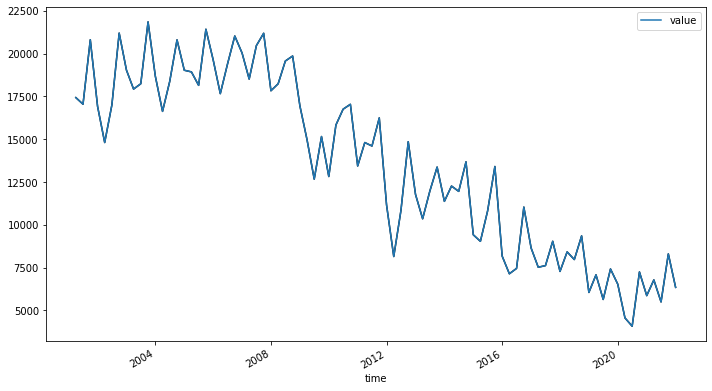

In [7]:
df_coal_ts.plot(cols=['value'])

In [ ]:
# import the param and model classes for Prophet model
from kats.models.prophet import ProphetModel, ProphetParams

# create a model param instance
params = ProphetParams() # additive mode gives worse results

# create a prophet model instance
m = ProphetModel(df_coal_ts, params)

# fit model simply by calling m.fit()
m.fit()

# make prediction for next 30 month
# fcst = m.predict(steps=30, freq="Q")

In [ ]:
# make prediction for next 30 month
fcst = m.predict(steps=30, freq="Q")